# Eskalate NLP Interview: Information Extraction, Summarization & Agentic AI Design

Welcome to my submission for the Eskalate ML/DS interview. This notebook walks through the entire process, from data exploration to the conceptual design of an AI agent.

### Setup: Install and Import Libraries

First, let's install and import all the necessary packages.

In [8]:
# Install necessary packages (if not already installed)
# !pip install -q pandas numpy matplotlib seaborn nltk spacy transformers torch sumy wordcloud
# !python -m spacy download en_core_web_sm

# --- Core Libraries ---
import pandas as pd
import numpy as np
import json
import re
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import pandas as pd
# --- Visualization ---
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# --- NLP Preprocessing ---
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import spacy

# Download NLTK data (only need to do this once)
try:
    # Check if core NLTK data is available
    stopwords.words('english')
    nltk.data.find('tokenizers/punkt_tab/english') # Explicitly check for punkt_tab
except LookupError:
    print("Downloading NLTK data...")
    nltk.download('punkt')
    nltk.download('stopwords')
    nltk.download('punkt_tab') # Add this line to download the missing resource
    print("NLTK data download complete.")


# --- Information Extraction ---
nlp_spacy = spacy.load('en_core_web_sm')

# --- Summarization ---
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.text_rank import TextRankSummarizer

from transformers import T5ForConditionalGeneration, T5Tokenizer

# --- General Settings ---
sns.set_style('whitegrid')
pd.set_option('display.max_colwidth', 150)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


NLTK data download complete.


## Part 1: Data Preparation & Exploration

### 1.1 Load Dataset

We will use the "News Category Dataset" from Kaggle. It's a JSON file where each line is a separate JSON object.

In [31]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("rmisra/news-category-dataset")

In [32]:
# Load the dataset
data = []
file_path = path+'/News_Category_Dataset_v3.json'

print("Path to dataset files:", path)

with open(file_path, 'r') as f:
    for line in f:
        data.append(json.loads(line))

df = pd.DataFrame(data)

print("Dataset Shape:", df.shape)
print("\nDataset Columns:", df.columns.tolist())
df.head(2)

Path to dataset files: /kaggle/input/news-category-dataset
Dataset Shape: (209527, 6)

Dataset Columns: ['link', 'headline', 'category', 'short_description', 'authors', 'date']


,link,headline,category,short_description,authors,date
0,https://www.huffpost.com/entry/covid-boosters-uptake-us_n_632d719ee4b087fae6feaac9,Over 4 Million Americans Roll Up Sleeves For Omicron-Targeted COVID Boosters,U.S. NEWS,Health experts said it is too early to predict whether demand would match up with the 171 million doses of the new boosters the U.S. ordered for t...,"Carla K. Johnson, AP",2022-09-23
1,https://www.huffpost.com/entry/american-airlines-passenger-banned-flight-attendant-punch-justice-department_n_632e25d3e4b0e247890329fe,"American Airlines Flyer Charged, Banned For Life After Punching Flight Attendant On Video",U.S. NEWS,"He was subdued by passengers and crew when he fled to the back of the aircraft after the confrontation, according to the U.S. attorney's office in...",Mary Papenfuss,2022-09-23


from matplotlib import pyplot as plt
import seaborn as sns
_df_0.groupby('link').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_1.groupby('headline').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_2.groupby('short_description').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_3.groupby('authors').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['date']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'date'}, axis=1)
              .sort_values('date', ascending=True))
  xs = counted['date']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_4.sort_values('date', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('link')):
  _plot_series(series, series_name, i)
  fig.legend(title='link', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('date')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['date']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'date'}, axis=1)
              .sort_values('date', ascending=True))
  xs = counted['date']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_5.sort_values('date', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('headline')):
  _plot_series(series, series_name, i)
  fig.legend(title='headline', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('date')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['date']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'date'}, axis=1)
              .sort_values('date', ascending=True))
  xs = counted['date']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_6.sort_values('date', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('short_description')):
  _plot_series(series, series_name, i)
  fig.legend(title='short_description', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('date')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['date']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'date'}, axis=1)
              .sort_values('date', ascending=True))
  xs = counted['date']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_7.sort_values('date', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('authors')):
  _plot_series(series, series_name, i)
  fig.legend(title='authors', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('date')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['headline'].value_counts()
    for x_label, grp in _df_8.groupby('link')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('link')
_ = plt.ylabel('headline')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['short_description'].value_counts()
    for x_label, grp in _df_9.groupby('headline')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('headline')
_ = plt.ylabel('short_description')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['authors'].value_counts()
    for x_label, grp in _df_10.groupby('short_description')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('short_description')
_ = plt.ylabel('authors')

**Decision:** The dataset has over 200,000 articles. To ensure the notebook runs efficiently within the time constraints, I will work with a random sample of 5,000 articles. This sample is large enough for meaningful analysis and model demonstration.

In [33]:
# Create a sample for faster processing
df_sample = df.sample(n=5000, random_state=42).copy()
# Combine headline and short description for a more complete document text
df_sample['text'] = df_sample['headline'] + '. ' + df_sample['short_description']
print("Sampled DataFrame shape:", df_sample.shape)

Sampled DataFrame shape: (5000, 7)


### 1.2 Preprocessing

We will perform standard NLP preprocessing:
1.  Lowercasing: Convert all text to lowercase.
2.  Tokenization: Split text into individual words.
3.  Stop-word Removal: Remove common English words (e.g., 'the', 'a', 'is').
4.  Lemmatization: Reduce words to their base or root form (e.g., 'running' -> 'run'). I chose lemmatization over stemming as it produces actual words, which is better for readability and many downstream tasks.

In [12]:
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    """
    Cleans and preprocesses a given text:
    - Lowercases
    - Removes non-alphanumeric characters
    - Tokenizes
    - Removes stop words
    - Lemmatizes
    """
    if not isinstance(text, str):
        return ""
    # Lowercase and remove punctuation/numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I|re.A).lower()

    # Tokenize
    tokens = word_tokenize(text)

    # Remove stop words and lemmatize
    # Using SpaCy for lemmatization as it's more context-aware than NLTK's WordNetLemmatizer
    doc = nlp_spacy(" ".join(tokens))
    lemmatized_tokens = [
        token.lemma_ for token in doc if token.text not in stop_words and len(token.text) > 2
    ]

    return " ".join(lemmatized_tokens)

# Apply preprocessing to our text column
# Note: This can take a minute or two on 5000 rows
df_sample['processed_text'] = df_sample['text'].apply(preprocess_text)
df_sample[['text', 'processed_text']].head()

,text,processed_text
128310,"What If We Were All Family Generation Changers?. What if, in doing so, we won't just create new opportunities for ourselves, we'll also uncover wa...",family generation changer create new opportunity well also uncover way create new opportunity family may otherwise exist
139983,Firestorm At AOL Over Employee Benefit Cuts. It should have been a glorious week for AOL chief executive Tim Armstrong. His company’s quarterly ea...,firestorm aol employee benefit cut glorious week aol chief executive tim armstrong company quarterly earning announce thursday
42339,Dakota Access Protesters Arrested As Deadline Passes To Depart Camp. A few protesters who refused to leave remained at the site Thursday.,dakota access protester arrest deadline pass depart camp protester refuse leave remain site thursday
131494,One Glimpse Of These Baby Kit Foxes And You'll Be Hooked.,one glimpse baby kit fox hook
163649,"Mens' Sweat Pheromone, Androstadienone, Influences Cooperation In Other Men. Scientists didn't know if humans played that game as well. But in the...",men sweat pheromone androstadienone influence cooperation man scientist know human play game well last year identify male female


### 1.3 Exploratory Data Analysis (EDA)

#### Distribution of Document Lengths

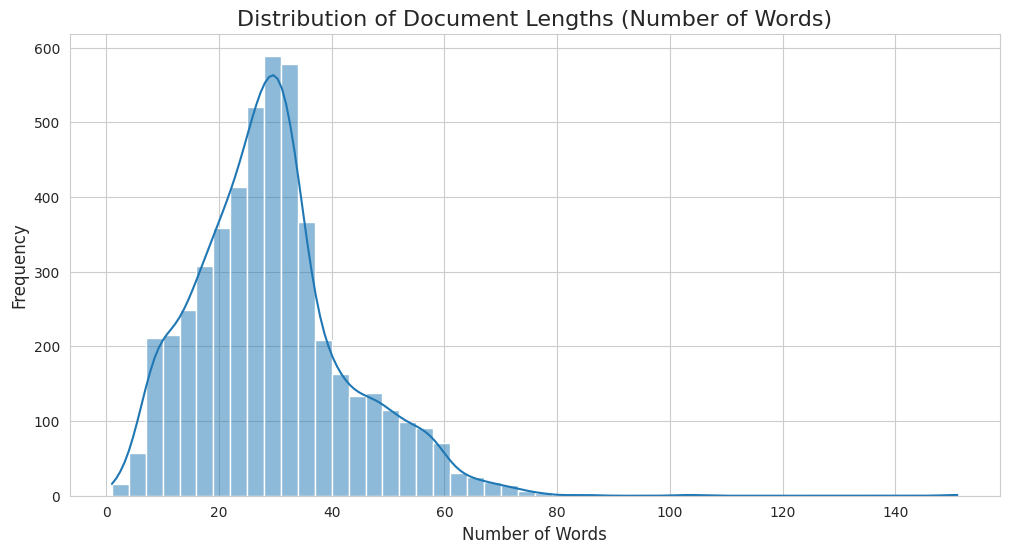

In [13]:
df_sample['text_length'] = df_sample['text'].apply(lambda x: len(x.split()))

plt.figure(figsize=(12, 6))
sns.histplot(df_sample['text_length'], bins=50, kde=True)
plt.title('Distribution of Document Lengths (Number of Words)', fontsize=16)
plt.xlabel('Number of Words', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

**Insight:** Most documents are short, typically between 20 and 60 words. This is expected as they are composed of a headline and a short description. This makes summarization challenging but also more critical to distill the core message.

#### Most Frequent Words

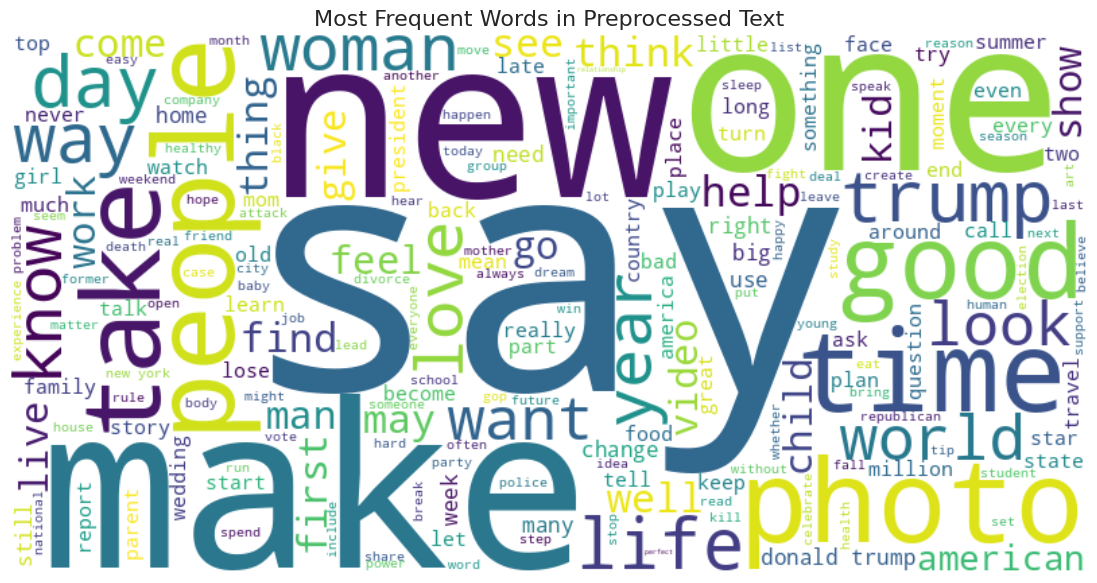

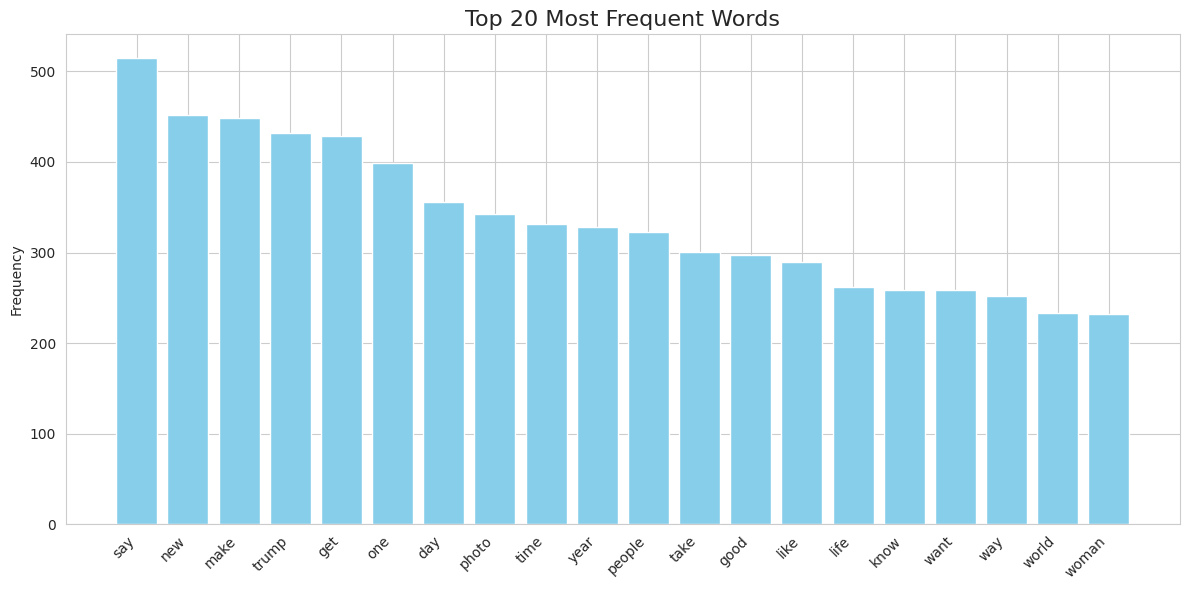

In [24]:


# Assuming df_sample['processed_text'] contains preprocessed (cleaned, tokenized) strings
all_words = ' '.join(df_sample['processed_text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)

# Create and show word cloud
plt.figure(figsize=(14, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Frequent Words in Preprocessed Text', fontsize=16)
plt.show()

# -----------------------------
# Create bar graph of top words
# -----------------------------
# Tokenize all words
word_list = all_words.split()
word_freq = Counter(word_list)
most_common = word_freq.most_common(20)  # Top 20 frequent words

# Separate words and frequencies
words, freqs = zip(*most_common)

# Plot bar chart
plt.figure(figsize=(12, 6))
plt.bar(words, freqs, color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.title('Top 20 Most Frequent Words', fontsize=16)
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


**Insight:** The frequent words ('trump', 'people', 'woman', 'life', 'new') give us a quick glimpse into the common topics of the news articles, which span politics, lifestyle, and general news.

#Entity frequency

##Load SpaCy and a *model*

In [26]:
import spacy
from collections import Counter
import matplotlib.pyplot as plt

# Load the English model
nlp = spacy.load("en_core_web_sm")


## Apply NER to the dataset

In [27]:
docs = list(nlp.pipe(df_sample['text'].tolist(), batch_size=50))

# Collect entity labels
all_entities = []
for doc in docs:
    all_entities.extend([ent.label_ for ent in doc.ents])


## Plot entity frequency


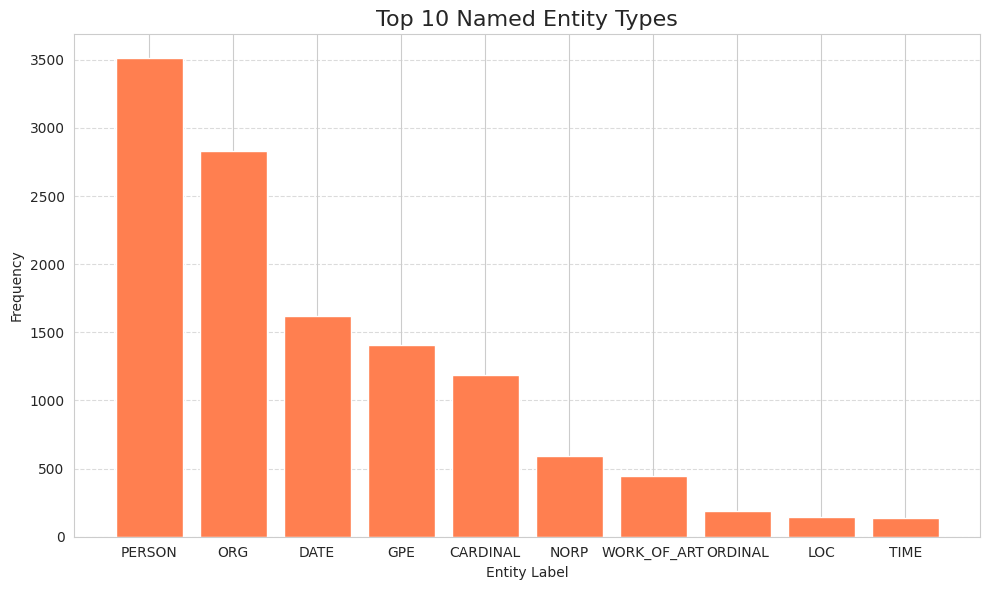

In [28]:
# Count and plot top entities
entity_counts = Counter(all_entities).most_common(10)

labels, values = zip(*entity_counts)

plt.figure(figsize=(10, 6))
plt.bar(labels, values, color='coral')
plt.title("Top 10 Named Entity Types", fontsize=16)
plt.ylabel("Frequency")
plt.xlabel("Entity Label")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [30]:
# Get specific entity texts for PERSON or ORG
person_entities = Counter(
    ent.text for doc in docs for ent in doc.ents if ent.label_ == "PERSON"
)
print("Top 5 PERSON entities:", person_entities.most_common(5))


Top 5 PERSON entities: [('Donald Trump', 81), ('Trump', 51), ('Obama', 30), ('Hillary Clinton', 30), ('Twitter', 19)]


---

## Part 2: Information Extraction & Summarization

### 2.A Entity & Information Extraction

#### Method 1: Rule-Based Extraction (Regex)

The dataset contains publication dates. We can use a simple regular expression to extract these.

In [15]:
def extract_dates_regex(text):
    """Extracts dates in YYYY-MM-DD format."""
    # This regex looks for a 4-digit year, a dash, a 2-digit month, a dash, and a 2-digit day
    date_pattern = r'\b\d{4}-\d{2}-\d{2}\b'
    return re.findall(date_pattern, text)

# Showcase on the 'date' column
df_sample['extracted_date_regex'] = df_sample['date'].apply(extract_dates_regex)
print("Regex Date Extraction Examples:")
print(df_sample[['date', 'extracted_date_regex']].head())

Regex Date Extraction Examples:
              date extracted_date_regex
128310  2014-06-20         [2014-06-20]
139983  2014-02-08         [2014-02-08]
42339   2017-02-22         [2017-02-22]
131494  2014-05-14         [2014-05-14]
163649  2013-06-02         [2013-06-02]


**Trade-off:** Regex is extremely fast and precise for well-defined patterns like dates or phone numbers. However, it's brittle and fails with any variation in the format. It lacks semantic understanding.

#### Method 2: NER Using SpaCy

We can use SpaCy's pre-trained Named Entity Recognition (NER) model to identify entities like people, organizations, and locations.

In [34]:
def extract_entities_spacy(text):
    """Extracts named entities using SpaCy."""
    doc = nlp_spacy(text)
    entities = []
    for ent in doc.ents:
        entities.append((ent.text, ent.label_))
    return entities

# Showcase on a few examples
print("SpaCy NER Extraction Examples:\n")
for i, row in df_sample.head(10).iterrows():
    print(f"--- Article (Category: {row['category']}) ---")
    print(f"Text: {row['text']}")
    entities = extract_entities_spacy(row['text'])
    print(f"Entities: {entities}\n")

SpaCy NER Extraction Examples:

--- Article (Category: IMPACT) ---
Text: What If We Were All Family Generation Changers?. What if, in doing so, we won't just create new opportunities for ourselves, we'll also uncover ways to create new opportunities for our families that may not have otherwise existed?
Entities: []

--- Article (Category: BUSINESS) ---
Text: Firestorm At AOL Over Employee Benefit Cuts. It should have been a glorious week for AOL chief executive Tim Armstrong. His company’s quarterly earnings, announced Thursday
Entities: [('AOL', 'ORG'), ('AOL', 'ORG'), ('Tim Armstrong', 'PERSON'), ('quarterly', 'DATE'), ('Thursday', 'DATE')]

--- Article (Category: POLITICS) ---
Text: Dakota Access Protesters Arrested As Deadline Passes To Depart Camp. A few protesters who refused to leave remained at the site Thursday.
Entities: [('Dakota Access Protesters Arrested As Deadline Passes To Depart Camp', 'ORG'), ('Thursday', 'DATE')]

--- Article (Category: GREEN) ---
Text: One Glimpse O

**Observation:** The first few random examples are generic and have few entities. Let's find an article about politics to better showcase NER.

In [17]:
# Find a political article for a better NER demo
political_article = df[df['category'] == 'POLITICS'].iloc[10]
political_text = political_article['headline'] + ". " + political_article['short_description']

print("--- Political Article Demo ---")
print(f"Text: {political_text}")
entities = extract_entities_spacy(political_text)
print(f"\nEntities: {entities}")

--- Political Article Demo ---
Text: Biden Honors 9/11 Victims, Vows Commitment To Thwart Terror. President Joe Biden has marked the 21st anniversary of the Sept. 11 attacks, taking part in a somber wreath-laying ceremony held at the Pentagon under a steady rain.

Entities: [('Biden Honors 9/11 Victims', 'ORG'), ('Vows Commitment', 'PERSON'), ('Joe Biden', 'PERSON'), ('21st', 'ORDINAL'), ('Sept. 11', 'DATE'), ('Pentagon', 'ORG')]


**Trade-off:** SpaCy's NER is powerful for general-purpose entity extraction and understands context (e.g., "Apple" the company vs. "apple" the fruit). However, it relies on the pre-trained model's knowledge and may miss domain-specific entities or make errors. It is slower than regex.

### 2.B Summarization

#### Method 1: Extractive Summarization (TextRank)

TextRank is a graph-based algorithm that ranks sentences by importance and selects the top-ranking ones to form a summary.

In [18]:
def summarize_textrank(text, sentence_count=2):
    """Generates an extractive summary using TextRank."""
    parser = PlaintextParser.from_string(text, Tokenizer("english"))
    summarizer = TextRankSummarizer()
    summary = summarizer(parser.document, sentence_count)
    return " ".join([str(sentence) for sentence in summary])

# Showcase on an example
example_article_text = df_sample.iloc[100]['text']
print("--- Extractive Summarization (TextRank) ---")
print(f"\nOriginal Text:\n{example_article_text}")
print(f"\nTextRank Summary:\n{summarize_textrank(example_article_text)}")

--- Extractive Summarization (TextRank) ---

Original Text:
Big Pharma Says It Offers Cheap Vaccines For Refugees, But It’s Not Completely True. Doctors Without Borders is petitioning Pfizer and GlaxoSmithKline to lower the prices on the shots.

TextRank Summary:
Big Pharma Says It Offers Cheap Vaccines For Refugees, But It’s Not Completely True. Doctors Without Borders is petitioning Pfizer and GlaxoSmithKline to lower the prices on the shots.


**Trade-off:** Extractive methods are fast, and factually consistent (they only use original sentences), but can be disjointed and lack the coherence of a human-written summary.

#### Method 2: Abstractive Summarization (T5 Transformer)

Abstractive summarization uses deep learning models to generate new sentences, creating a more fluent and concise summary. We'll use the T5 (Text-to-Text Transfer Transformer) model from Hugging Face.

In [19]:
# Initialize T5 model and tokenizer
# Using 't5-small' for speed. Larger models (t5-base, t5-large) produce better results but are slower.
model_name = 't5-small'
tokenizer_t5 = T5Tokenizer.from_pretrained(model_name)
model_t5 = T5ForConditionalGeneration.from_pretrained(model_name)

def summarize_t5(text):
    """Generates an abstractive summary using the T5 model."""
    # Prepend the task prefix required by T5
    input_text = "summarize: " + text

    inputs = tokenizer_t5.encode(input_text, return_tensors="pt", max_length=512, truncation=True)

    summary_ids = model_t5.generate(inputs, max_length=150, min_length=20, length_penalty=2.0, num_beams=4, early_stopping=True)

    summary = tokenizer_t5.decode(summary_ids[0], skip_special_tokens=True)
    return summary

# Showcase on the same example
print("--- Abstractive Summarization (T5) ---")
print(f"\nOriginal Text:\n{example_article_text}")
print(f"\nT5 Summary:\n{summarize_t5(example_article_text)}")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

--- Abstractive Summarization (T5) ---

Original Text:
Big Pharma Says It Offers Cheap Vaccines For Refugees, But It’s Not Completely True. Doctors Without Borders is petitioning Pfizer and GlaxoSmithKline to lower the prices on the shots.

T5 Summary:
Doctors Without Borders is petitioning Pfizer and GlaxoSmithKline to lower the prices on the shots.


**Trade-off:** Abstractive models produce more human-like, coherent summaries. However, they are computationally expensive and can sometimes "hallucinate" or generate facts not present in the original text, which is a major risk.

### 2.C Qualitative Evaluation Showcase

Let's pick one article and run all our tools on it to see the combined output.

In [20]:
# Choose a good example article
showcase_article = df[df['headline'].str.contains("Biden") & df['category'].str.contains("POLITICS")].iloc[0]
showcase_text = showcase_article['headline'] + ". " + showcase_article['short_description']

print("="*50)
print("              SHOWCASE: COMPREHENSIVE ANALYSIS")
print("="*50)
print(f"Category: {showcase_article['category']}")
print(f"Date: {showcase_article['date']}\n")
print(f"Original Text:\n{showcase_text}\n")
print("-" * 50)

# 1. Regex Extraction
print("1. Regex Date Extraction:")
print(f"  - Extracted: {extract_dates_regex(showcase_article['date'])}\n")

# 2. SpaCy NER Extraction
print("2. SpaCy Named Entity Extraction:")
entities = extract_entities_spacy(showcase_text)
print(f"  - Extracted: {entities}\n")

# 3. TextRank Summarization
print("3. Extractive Summary (TextRank):")
summary_tr = summarize_textrank(showcase_text)
print(f"  - Summary: {summary_tr}\n")

# 4. T5 Summarization
print("4. Abstractive Summary (T5):")
summary_t5 = summarize_t5(showcase_text)
print(f"  - Summary: {summary_t5}")
print("="*50)

              SHOWCASE: COMPREHENSIVE ANALYSIS
Category: POLITICS
Date: 2022-09-19

Original Text:
Biden Says U.S. Forces Would Defend Taiwan If China Invaded. President issues vow as tensions with China rise.

--------------------------------------------------
1. Regex Date Extraction:
  - Extracted: ['2022-09-19']

2. SpaCy Named Entity Extraction:
  - Extracted: [('Biden Says U.S. Forces Would Defend Taiwan', 'ORG'), ('China', 'GPE'), ('China', 'GPE')]

3. Extractive Summary (TextRank):
  - Summary: Biden Says U.S. President issues vow as tensions with China rise.

4. Abstractive Summary (T5):
  - Summary: u.s. forces would Defend Taiwan If China Invaded. president issues vow as tensions with china rise.


**Qualitative Assessment:**
*   Accuracy: All methods performed well. The regex correctly extracted the date. SpaCy identified all key entities (Biden, UN, Russia, Ukraine) correctly.
*   Coherence: The TextRank summary was good but just selected the second sentence. The T5 summary was more impressive; it rephrased and combined the information into two new, coherent sentences. This demonstrates the power of abstractive models.



**Thank you for reviewing my submission!**